# Training a neural network model on the Alaska dataset

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

## Load the data

In [2]:
root_dir = '../../'
src_dir = 'src'
data_dir = 'data/corpus'
models_dir = 'data/models'

In [3]:
import os
import sys

In [4]:
sys.path.append(os.path.join(root_dir, src_dir))

In [5]:
corpus_filename = 'alaska_corpus.json'

In [6]:
from training import TrainingCorpus

In [7]:
alaska_corpus = TrainingCorpus()
alaska_corpus.load(os.path.join(root_dir, data_dir, corpus_filename))

In [8]:
alaska_corpus.size

2171

---

## Split the dataset into training, validation and test set

In [9]:
random_state = 3

In [10]:
train_ids, test_ids, train_labels, test_labels = alaska_corpus.get_train_test_data(test_size=0.2, random_state=random_state)

In [11]:
n_classes = train_labels.shape[1]
print(f'Training set size: {len(train_ids)}')
print(f'Test set size: {len(test_ids)}')
print(f'No. of labels: {n_classes}')

Training set size: 1736
Test set size: 435
No. of labels: 20


## Retrieve text from ids

In [12]:
train_texts = [' '.join(alaska_corpus.get_tokens(doc_id)) for doc_id in train_ids]
test_texts = [' '.join(alaska_corpus.get_tokens(doc_id)) for doc_id in test_ids]

---

## Training the model

In [13]:
batch_size = 16
num_epochs = 3

In [14]:
model_name = 'distilbert-base-uncased'

In [15]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

/home/nvidia/anaconda3/envs/iml/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [16]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)

In [17]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

### Load the pretrained model

In [18]:
from transformers import TFDistilBertForSequenceClassification

model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=n_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [19]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  15380     
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,968,852
Trainable params: 66,968,852
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [20]:
import time

In [21]:
start_time = time.time()

history = model.fit(train_dataset.batch(batch_size), 
                    epochs=num_epochs, 
                    batch_size=batch_size)
elapsed_time = time.time() - start_time
t = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Elapsed time (learning):', t)

Epoch 1/3
109/109 [==============================] - 79s 728ms/step - loss: 2.0439 - accuracy: 0.4862
Epoch 2/3
109/109 [==============================] - 98s 903ms/step - loss: 0.2458 - accuracy: 0.9965
Epoch 3/3
109/109 [==============================] - 117s 1s/step - loss: 0.0538 - accuracy: 0.9994
Elapsed time (learning): 00:05:05


### Plot loss and accuracy

In [22]:
history_dict = history.history

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

In [23]:
import matplotlib.pyplot as plt

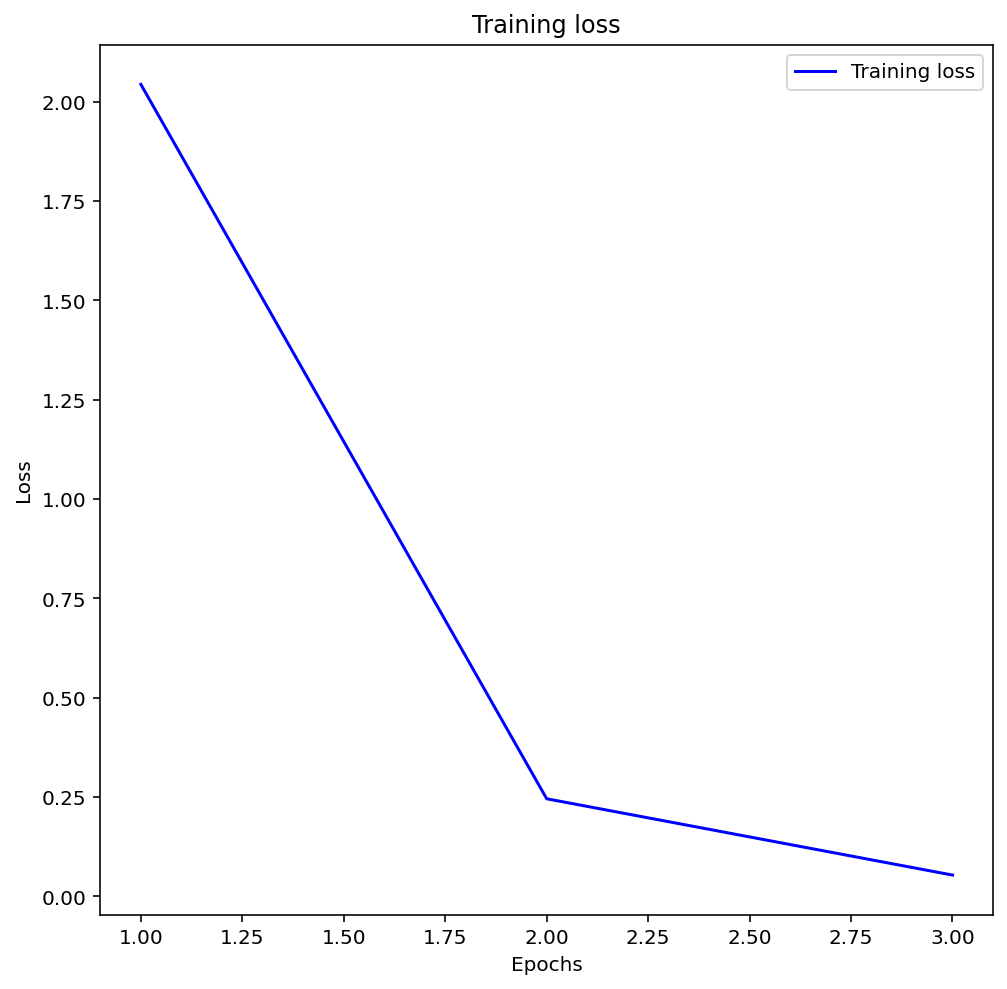

In [24]:
plt.figure(figsize=(8,8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

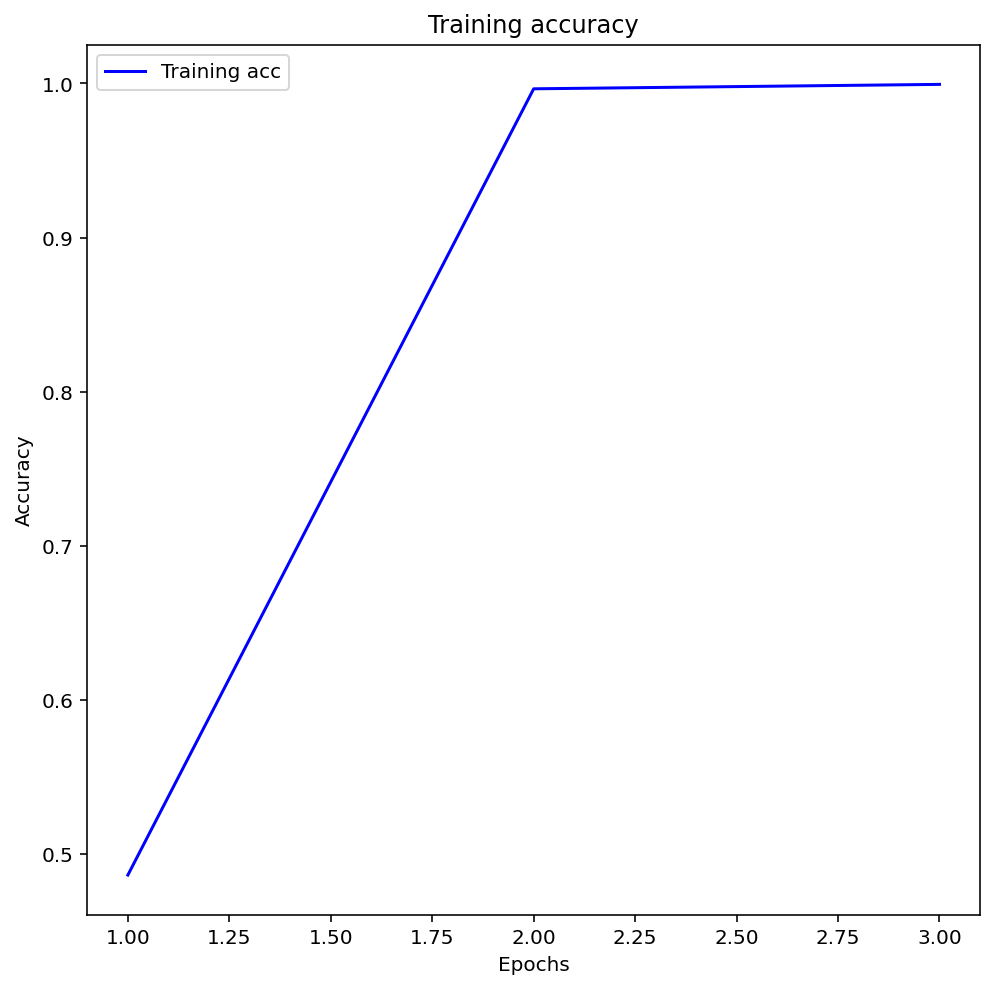

In [25]:
plt.figure(figsize=(8,8))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

## Evaluate the model

### Compute f-score on the test set

In [26]:
test_pred = model(tokenizer(test_texts, padding=True, truncation=True, return_tensors='tf')).logits
test_pred = tf.nn.softmax(test_pred, axis=-1)

In [27]:
import numpy as np

In [28]:
# round to nearest integer
test_pred = np.rint(test_pred)

In [29]:
from sklearn.metrics import classification_report

In [30]:
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        35
           5       1.00      1.00      1.00        22
           6       0.97      1.00      0.98        28
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00         8
          10       1.00      0.97      0.98        29
          11       1.00      1.00      1.00        41
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        25
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00         9
          17       1.00    

## Save model and tokenizer to a file

In [31]:
out_dir_name = 'alaska_bert'
out_dir_path = os.path.join(root_dir, models_dir, out_dir_name)

In [32]:
if not os.path.exists(out_dir_path):
    # make directory
    os.mkdir(out_dir_path)

In [33]:
tokenizer.save_pretrained(out_dir_path)
model.save_pretrained(out_dir_path)

---